<a href="https://colab.research.google.com/github/skhabiri/DS17-Unit-2-Build/blob/master/notebooks/skhabiri_LS_DS_build2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Week Project


This post evaluates different multi-class classification techniques on forest dataset provided by Jock A. Blackard and Colorado State University. 

> Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science
* **Dataset:** [https://archive.ics.uci.edu/ml/datasets/Covertype](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [ ]:
# Import data
import pandas as pd
import numpy as np
!pip install category_encoders==2.*


data = pd.read_csv('https://raw.githubusercontent.com/skhabiri/DS17-Unit-2-Build/master/data/train.csv')
print(data.shape)
data.head()

     |████████████████████████████████| 81kB 1.3MB/s 
(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [ ]:
#render dataframe as html
html = data.head().to_html()

#write html to file
text_file = open("index.html", "w")
text_file.write(html)
text_file.close()

In [ ]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

import pickle

import random 
%matplotlib inline
from scipy import stats



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Datatypes
data.dtypes

Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                      

In [ ]:
data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
# Some of the features are largely skewed
data.skew().sort_values(ascending=False)[:30]

Soil_Type8          122.963409
Soil_Type25         122.963409
Soil_Type28          40.955261
Soil_Type9           38.849712
Soil_Type36          38.849712
Soil_Type27          31.704896
Soil_Type21          30.695081
Soil_Type34          26.161230
Soil_Type37          21.018939
Soil_Type19          18.048915
Soil_Type26          16.645076
Soil_Type18          15.781426
Soil_Type35          12.052838
Soil_Type16          11.387050
Soil_Type20          10.286265
Soil_Type5            9.416209
Soil_Type14           9.300318
Soil_Type12           7.977205
Soil_Type24           7.474026
Soil_Type31           6.524804
Soil_Type22           6.391991
Soil_Type1            6.294716
Soil_Type11           5.854551
Soil_Type40           5.475256
Soil_Type13           5.366836
Wilderness_Area2      5.228781
Soil_Type17           4.663945
Soil_Type33           4.646742
Soil_Type2            4.617019
Soil_Type6            4.506716
dtype: float64

* The dataset has 15120 rows and 56 columns. This is a multiclass classification with "Cover_Type" as the target label. Wilderness_Area and Soil_Type columns have been encoded with One Hot Encoder.

* In order to visualize data better, we will convert all the Soil_Types and Wilderness_Areas columns into two categorical features "Soil_Type" and "Wilderness_Area"

In [ ]:
data1 = data.copy()

# Encode Soil_Types and Wilderness_Area features into two new features
ohe_bool = []
enc_cols = ["Wilderness_Area", "Soil_Type"]
for idx, val in enumerate(enc_cols):
  val_df = data.filter(regex=val, axis=1)
  print(f"{idx} {val} is ohe? {((val_df.sum(axis=1)) == 1).all()}")
  data1[val] = val_df.dot(val_df.columns)
  # Convert the constructed columns into int
  data1[val] = data1[val].astype('str').str.findall(r"(\d+)").str[-1].astype('int')
  data1 = data1.drop(val_df.columns, axis=1)

# Reorder the columns
data1 = data1.iloc[:,data1.columns!="Cover_Type"].merge(data1["Cover_Type"], left_index=True, right_index=True)
data1.tail(), data1.shape

0 Wilderness_Area is ohe? True
1 Soil_Type is ohe? True


(          Id  Elevation  Aspect  ...  Wilderness_Area  Soil_Type  Cover_Type
 15115  15116       2607     243  ...                3          4           3
 15116  15117       2603     121  ...                3          4           3
 15117  15118       2492     134  ...                3          4           3
 15118  15119       2487     167  ...                3          4           3
 15119  15120       2475     197  ...                3          2           3
 
 [5 rows x 14 columns], (15120, 14))

In [ ]:
data1.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,2.800397,19.171362,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,1.119832,12.626960,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,2.000000,10.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,3.000000,17.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,4.000000,30.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,4.000000,40.000000,7.000000


In [ ]:
#render dataframe as html
html = data1.describe().to_html()

#write html to file
text_file = open("index.html", "w")
text_file.write(html)
text_file.close()

* Heatmap of correlation matrix shows Elevation and Soil_Type is highly correlated, and Hillshade_3pm is reversely correlated with Hillshade_9am. 

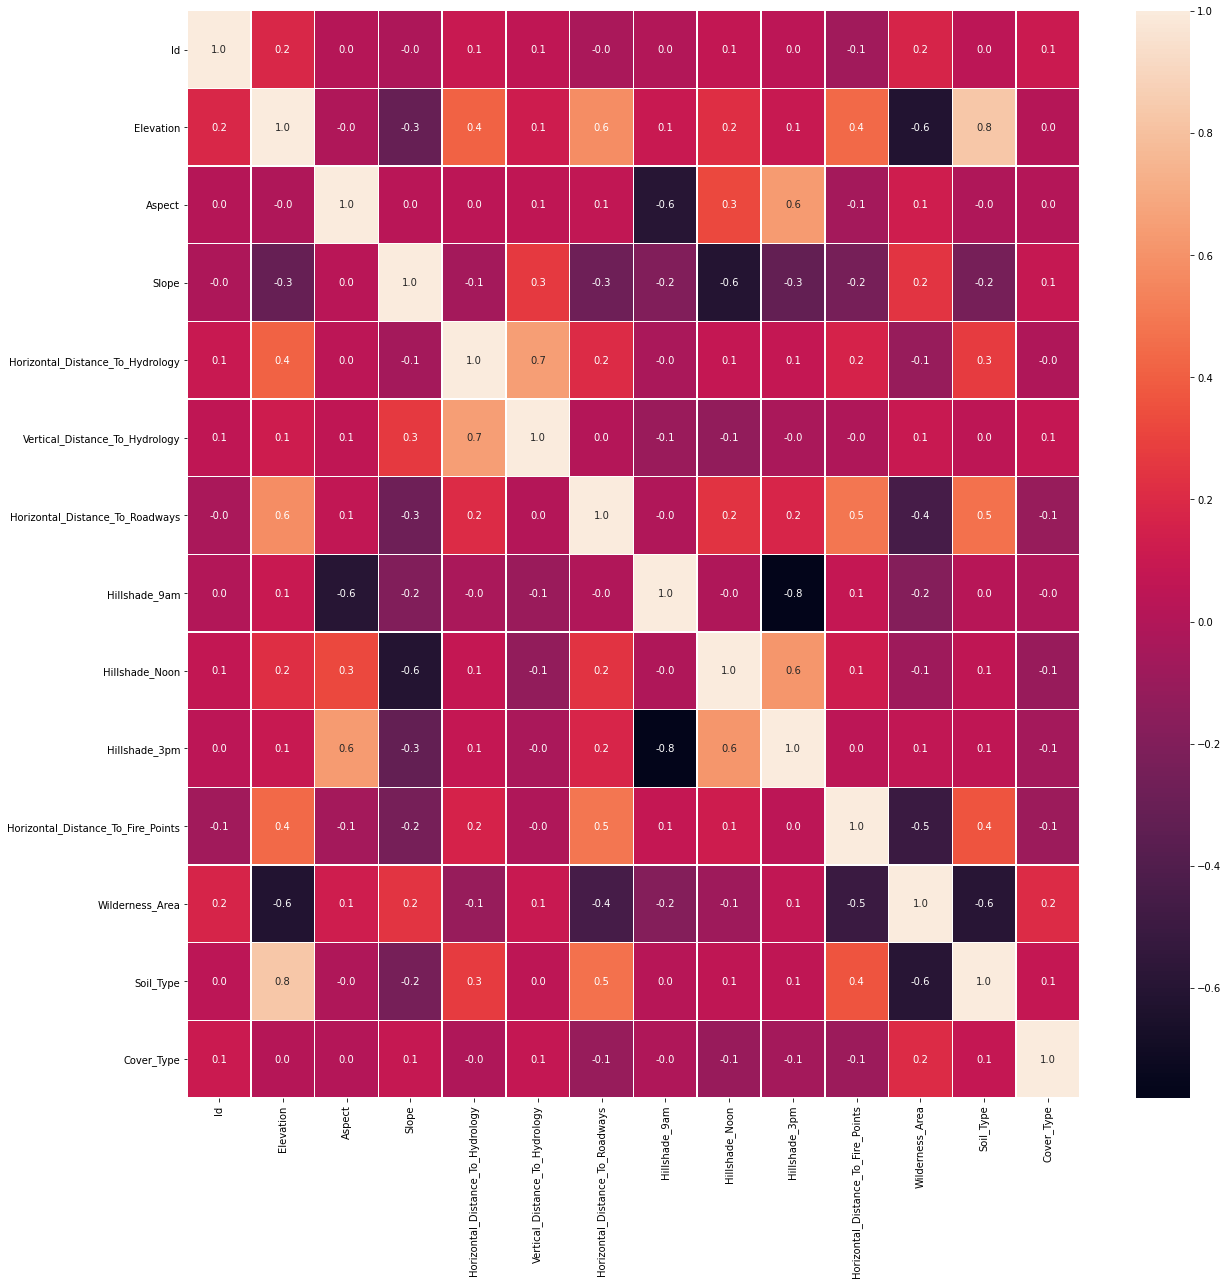

In [ ]:
fig,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data1.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

In [ ]:
# # get the first two highest correlation factors
# corr_max = sorted([data1.corr().iloc[i+1:,i].abs().max() for i in range(len(data1.columns)-1)])
# data1.corr().where(data1.corr().isin([-1*i for i in corr_max[-2:]]+corr_max[-2:])).dropna(how='all', axis=0).dropna(how='all',axis=1)

It seems "Elevation" is an important parameter in separating different classes.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


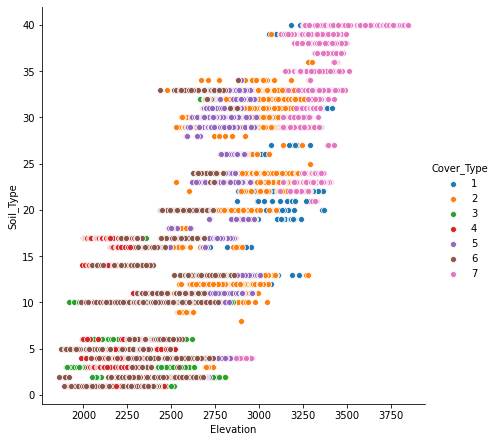

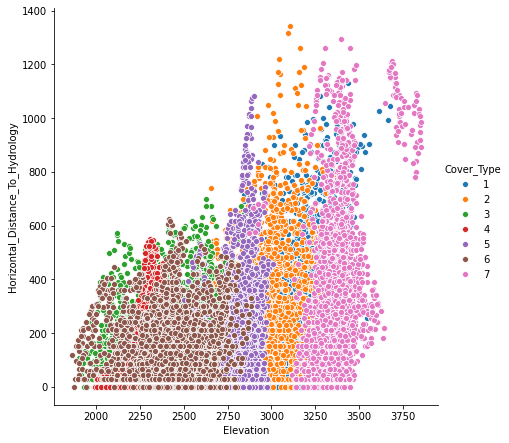

In [ ]:
sns.pairplot(data1, hue="Cover_Type", size=6, x_vars="Elevation",y_vars="Soil_Type" )
sns.pairplot(data1, hue="Cover_Type", size=6, x_vars="Elevation",y_vars="Horizontal_Distance_To_Hydrology" )
plt.show()

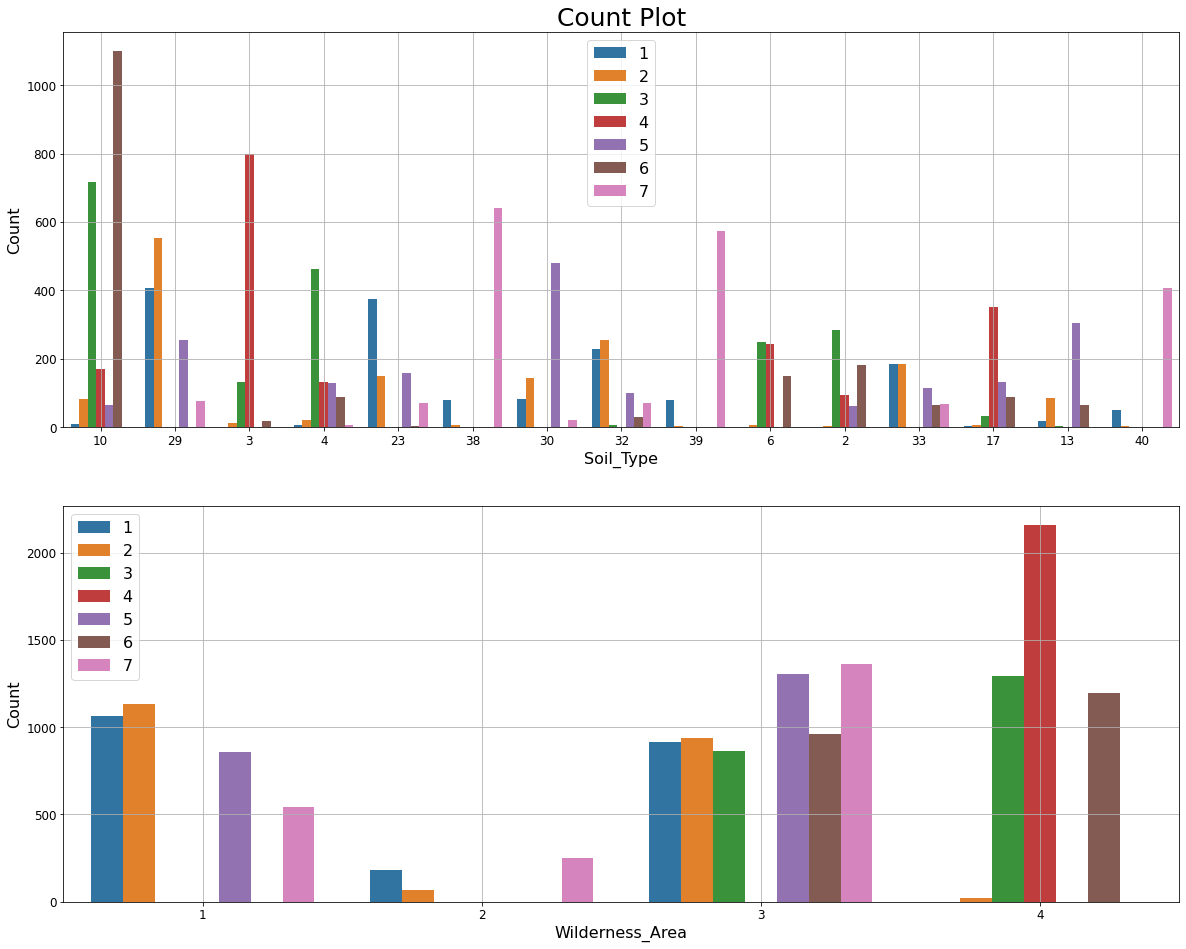

In [ ]:
#Plot for Category2
fig, ax =plt.subplots(2,1, figsize=(20,16))

a = sns.countplot(x="Soil_Type", hue="Cover_Type", data=data1, order=data1["Soil_Type"].value_counts().index[:15], ax=ax[0])
b = sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data1, ax=ax[1])

a.axes.set_title("Count Plot",fontsize=25)
a.set_xlabel("Soil_Type",fontsize=16)
a.set_ylabel("Count",fontsize=16)
a.tick_params(labelsize=12)
a.grid()
a.legend(fontsize=16)

b.set_xlabel("Wilderness_Area",fontsize=16)
b.set_ylabel("Count",fontsize=16)
b.tick_params(labelsize=12)
b.grid()
b.legend(fontsize=16)

plt.show()

* Soil_Type10 shows a significant class distinction for Cover_Type=6
* Similarly Wilderness_Area4 and Cover_Type=4 are strongly associated

* Soil_Type15 and Soil_Type7 are constant.
* Id is a unique identifier for each observation and can be dropped.

In [ ]:
data.nunique().sort_values(ascending=False)

Id                                    15120
Horizontal_Distance_To_Roadways        3250
Horizontal_Distance_To_Fire_Points     2710
Elevation                              1665
Vertical_Distance_To_Hydrology          423
Horizontal_Distance_To_Hydrology        400
Aspect                                  361
Hillshade_3pm                           247
Hillshade_9am                           176
Hillshade_Noon                          141
Slope                                    52
Cover_Type                                7
Soil_Type29                               2
Soil_Type28                               2
Soil_Type5                                2
Soil_Type4                                2
Soil_Type3                                2
Soil_Type2                                2
Soil_Type1                                2
Wilderness_Area4                          2
Wilderness_Area3                          2
Wilderness_Area2                          2
Wilderness_Area1                

* The graph below shows the data skewness for "Horizontal_Distance_To_Hydrology"

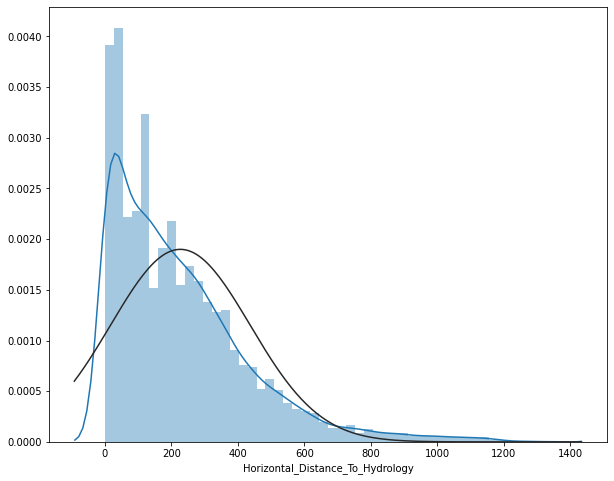

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(data1['Horizontal_Distance_To_Hydrology'], fit=stats.norm)


Our target label is "Cover_Type"
We will drop imb% imbalance low cardinal features. We also drop "id" column.

In [ ]:
def skew_col(X, imb=1):
  '''
  Returns the sorted list of feature names 
  with imbalance exceeding imb value
  '''
  X=X.copy()

  mask2 = pd.Series({col: X[col].value_counts().
                     max()/X[col].value_counts().
                     sum() for col in X.nunique().index}).sort_values(ascending=False)
  
  mask2 = mask2[mask2 >= imb]

  drop_cols = ["Id"] + list(mask2.index) 
  return drop_cols

### Train Test split:
Target = "Cover_Type"

In [ ]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(data, train_size=0.80, test_size=0.20, stratify=data["Cover_Type"], 
                                random_state=42)
print(f'train: {train.shape}, val: {val.shape}')


# Separate class label and data 
y_train = train["Cover_Type"]
X_train = train.drop("Cover_Type", axis=1)
y_val = val["Cover_Type"]
X_val = val.drop("Cover_Type", axis=1)

train: (12096, 56), val: (3024, 56)


* Check for Nan value

In [ ]:
X_train.isna().sum(axis=0).sum()

0

In [ ]:
def wrangle(X, cols, drop_count=1):
  '''
  drops drop_count number of features from cols starting from index=0 (Id)
  '''  
  X = X.copy()
  X = X.drop(labels=cols[:drop_count], axis=1)
  return X


### Baseline model

In [ ]:
y_train.value_counts(normalize=True)

7    0.142857
6    0.142857
5    0.142857
4    0.142857
3    0.142857
2    0.142857
1    0.142857
Name: Cover_Type, dtype: float64

### Pipeline fit and metrics functions

In [ ]:
# Getting the name of the estimator's classifier from a dictionary
def clf_name(estimator, est_dict):
  return est_dict[estimator][0].__class__.__name__

In [ ]:
def fit_rep(estimator, X_train, y_train, X_val, y_val, kwargs_dict):
  estimator.set_params(functiontransformer__kw_args = kwargs_dict)

  print("\n fitting ...")
  estimator.fit(X_train, y_train)

  print("\n getting X_train transformed column labels")
  feat_name = estimator.named_steps['functiontransformer'].transform(X_train).columns
  print("X_train cols:", len(X_train.columns), "X_fit cols:", len(feat_name))

  print("\n predicting ...")
  y_pred = estimator.predict(X_val)
  
  score_train = estimator.score(X_train, y_train)
  score_val = estimator.score(X_val, y_val)

  print("\n score ...")
  print('Training score', score_train)
  print('Validation score', score_val)

  accuracy_score_train = accuracy_score(y_train, estimator.predict(X_train))
  accuracy_score_val = accuracy_score(y_val, y_pred)

  print("\n Accuracy ...")
  print('Training Accuracy', accuracy_score_train)
  print('Validation Accuracy', accuracy_score_val)

  return estimator, y_pred, feat_name

In [ ]:
def metric_rep(estimator, X_val, y_val):
  
  print("\n predicting y ...")
  y_pred = estimator.predict(X_val)
  
  print("\n plotting confusion matrix ...")
  plt.rcParams['figure.dpi'] = 80
  plot_confusion_matrix(estimator, X_val, y_val, values_format='.0f', xticks_rotation='vertical')
  
  print("\n calculating confusion matrix ...")
  C = pd.DataFrame(confusion_matrix(y_val, y_pred))
  print(C)
  truth_sum = C.sum(axis=1)
  predict_sum = C.sum(axis=0)
  pred_t = pd.Series([C.iloc[i,i] for i in range(len(C))])

  recall = pred_t / truth_sum
  precision = pred_t / predict_sum
  accuracy = pred_t.sum() / truth_sum.sum()

  print("\n classification report ...")
  print(classification_report(y_val, y_pred, target_names=estimator.classes_.astype(str)))

  print(f"******\n accuracy is {accuracy:.2f}\n******")

  return accuracy, precision, recall

### Estimators

Here is a series of pipeline that we will evaluate.

In [ ]:
# LogisticRegression
lr = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    StandardScaler(),
    LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                        fit_intercept=True, intercept_scaling=1, class_weight=None, 
                        random_state=42, solver='lbfgs', max_iter=100, 
                        multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None)
    )

In [ ]:
# RidgeClassifier
rc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    StandardScaler(),
    RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, 
                    max_iter=None, tol=0.001, class_weight=None, solver='auto', 
                    random_state=42)
    )

In [ ]:
# RandomForestClassifier
rfc = make_pipeline(
        FunctionTransformer(wrangle, validate=False), 
        # ce.OneHotEncoder(use_cat_names=True), 
        # SimpleImputer(strategy='median'), 
        RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=14, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
  ) 

In [ ]:
# GradientBoostingClassifier
gbc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(), 
    # SimpleImputer(strategy='median'), 
    GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                               subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                               init=None, random_state=None, max_features=None, verbose=0, 
                               max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                               validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
)

In [ ]:
# XGBoost
# It can handle NaNs
xgbc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(),
    XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=100, random_state=42,
                  verbosity=1, objective='reg:logistic', booster='gbtree', n_jobs=4,
                  min_split_loss=0, subsample=0.5, sampling_method='uniform',
                  tree_method='auto', num_parallel_tree=1, eval_metric='merror')
)

### Variables and Tunning Parameters

In [ ]:
# Dropping Id column and constant features
drop_cols = skew_col(X_train, imb=1)
drop_count = len(drop_cols)
kwargs_dict ={'drop_count': drop_count,
              'cols': drop_cols
              }
kwargs_dict

{'cols': ['Id', 'Soil_Type15', 'Soil_Type7'], 'drop_count': 3}

* Classifiers Hyper Parameters

In [ ]:
#List of estimators
reg_list = [lr, rc]
tree_list = [rfc, gbc, xgbc]
est = reg_list[:] + tree_list[:]

In [ ]:
# Logestic Regression
lr_par_names = ["solver"]
solver_lr = ['lbfgs', 'newton-cg', 'sag', 'saga']
lr_param_ranges = [solver_lr]

# Ridge Classifier
rc_par_names = ["alpha"]
alpha_rc = [0.01, 0.1, 1, 10, 100]
rc_param_ranges = [alpha_rc]

# Random Forest Classifier
rfc_par_names = ["max_features", "max_depth", "min_samples_split", "min_samples_leaf", "criterion"]
max_features_rfc = np.arange(6,30,2)
max_depth_rfc = range(6,20,2)
min_samples_split_rfc = np.linspace(2, 40, 10, endpoint=True).astype(int)
min_samples_leaf_rfc = np.linspace(2, 40, 10, endpoint=True).astype(int)
criterion_rfc = ["gini", "entropy"]
rfc_param_ranges = [max_features_rfc, max_depth_rfc, min_samples_split_rfc, min_samples_leaf_rfc, criterion_rfc]

# Gradient Boost Classifier
gbc_par_names = ["max_features", "max_depth", "min_samples_split", "min_samples_leaf"]
max_features_gbc = np.arange(2,30,2)
max_depth_gbc = range(2,16,2)
min_samples_split_gbc = np.linspace(2, 40, 10, endpoint=True).astype(int)
min_samples_leaf_gbc = np.linspace(2, 40, 10, endpoint=True).astype(int)
criterion_gbc = ["gini", "entropy"]
gbc_param_ranges = [max_features_gbc, max_depth_gbc, min_samples_split_gbc, min_samples_leaf_gbc]

# XGBoost Classifier
xgbc_par_names = ["colsample_bytree", "max_depth", "min_child_weight", "learning_rate", "n_estimators"]
colsample_bytree_xgbc = np.arange(0.5,1.01,0.1)
max_depth_xgbc = range(2,16,2)
min_child_weight_xgbc = np.linspace(1, 40, 10, endpoint=True).astype(int)
learning_rate_xgbc = [0.01, 0.1, 0.3]
n_estimators_xgbc = [100, 250, 500]
xgbc_param_ranges = [colsample_bytree_xgbc, max_depth_xgbc, min_child_weight_xgbc, learning_rate_xgbc, n_estimators_xgbc]


est_dict = {
    lr: [LogisticRegression(), lr_par_names, lr_param_ranges],
    rc: [RidgeClassifier(),rc_par_names, rc_param_ranges],
    rfc: [RandomForestClassifier(),rfc_par_names,rfc_param_ranges],
    gbc: [GradientBoostingClassifier(), gbc_par_names,gbc_param_ranges],
    xgbc: [XGBClassifier(), xgbc_par_names, xgbc_param_ranges]
            }

### Fit the estimators and get the metrics


********** LogisticRegression **********

 fitting ...

 getting X_train transformed column labels
X_train cols: 55 X_fit cols: 52

 predicting ...

 score ...
Training score 0.7132936507936508
Validation score 0.6888227513227513

 Accuracy ...
Training Accuracy 0.7132936507936508
Validation Accuracy 0.6888227513227513

 predicting y ...

 plotting confusion matrix ...

 calculating confusion matrix ...
     0    1    2    3    4    5    6
0  293   78    1    0   14    0   46
1  102  214   13    0   78   21    4
2    0    4  225   54   19  130    0
3    0    0   32  375    0   25    0
4    4   68   10    0  322   28    0
5    0    5  103   28   18  278    0
6   55    0    0    0    1    0  376

 classification report ...
              precision    recall  f1-score   support

           1       0.65      0.68      0.66       432
           2       0.58      0.50      0.53       432
           3       0.59      0.52      0.55       432
           4       0.82      0.87      0.84       4

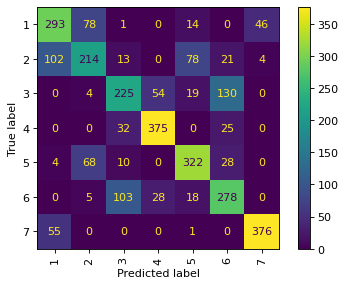

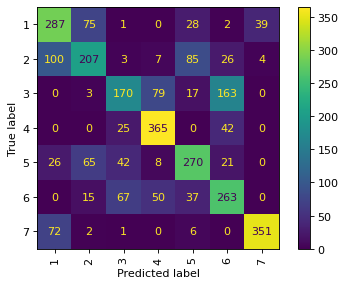

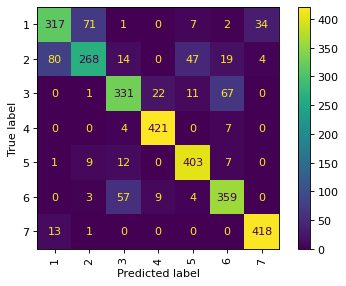

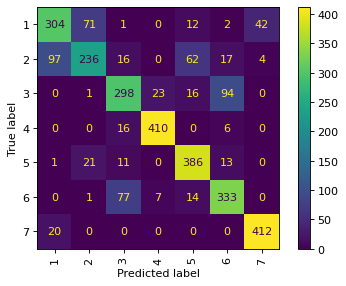

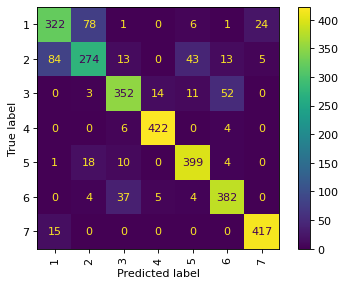

In [ ]:
# fit the list of estimators
empt_list = [np.NaN]*len(est)
feat_name = empt_list.copy()
y_pred = empt_list.copy()
accuracy = empt_list[:]
precision = empt_list.copy()
recall = empt_list.copy()


for i, estimator in enumerate(est):
  print(f"\n********** {est_dict[estimator][0].__class__.__name__} **********")
  (est[i], y_pred[i], feat_name[i]) = fit_rep(estimator, X_train, y_train, X_val, y_val, kwargs_dict)
  (accuracy[i], precision[i], recall[i]) = metric_rep(estimator, X_val, y_val)
  # Saving model to disk
  pickle.dump([accuracy[i], precision[i], recall[i]], open(f'{est_dict[estimator][0].__class__.__name__}.pkl','wb'))


In [ ]:
accuracy

[0.6888227513227513,
 0.6326058201058201,
 0.8323412698412699,
 0.7867063492063492,
 0.8492063492063492]

In [ ]:
precision

[0    0.645374
 1    0.579946
 2    0.585938
 3    0.820569
 4    0.712389
 5    0.576763
 6    0.882629
 dtype: float64, 0    0.591753
 1    0.564033
 2    0.550162
 3    0.717092
 4    0.609481
 5    0.508704
 6    0.890863
 dtype: float64, 0    0.771290
 1    0.759207
 2    0.789976
 3    0.931416
 4    0.853814
 5    0.778742
 6    0.916667
 dtype: float64, 0    0.720379
 1    0.715152
 2    0.711217
 3    0.931818
 4    0.787755
 5    0.716129
 6    0.899563
 dtype: float64, 0    0.763033
 1    0.726790
 2    0.840095
 3    0.956916
 4    0.861771
 5    0.837719
 6    0.934978
 dtype: float64]

In [ ]:
## Average tree depth
for i, estimator in enumerate([rfc]):
  print(f"\n********** {est_dict[estimator][0].__class__.__name__} **********")
  max_depth = list()
  for tree in estimator.named_steps[clf_name(estimator, est_dict).lower()].estimators_:
    max_depth.append(tree.tree_.max_depth)
  print(f"avg max depth {sum(max_depth) / len(max_depth):0.1f} for {len(max_depth)} trees")



********** RandomForestClassifier **********
avg max depth 14.0 for 10 trees


### feature_importances and permutation_importance

In the presence of all the features, feature_importance_ of Id column ranks relatively high. Hence, feature_importance_ by itself cannot be a deciding factor.





In [ ]:
selected_feat = feat_name[0]

In [ ]:
# sklearn permutation_importances
from sklearn.inspection import permutation_importance
def important_features(estimator, est_dict, X_val, y_val, selected_feat, n_feat=25, n_repeats=5):
  '''
  n_feat: number of top features
  n_repeats: number of prmutations per column
  '''
  #permutation importance does not see function transformer and column reduction. Hence permutates over original X_val columns
  # permutation shuffles each column of X_val n_repeats time and take a mean of those n_repeats importance values
  result = permutation_importance(estimator, X_val, y_val, 
                                n_repeats=n_repeats, random_state=42)
  print(result.keys())
  df = pd.DataFrame({'feature': X_val.columns,
                   'importances_mean': np.round(result['importances_mean'], 4),
                   'importances_std': result['importances_std']
                   })

  # estimator selected columns
  df = df[df.loc[:,"feature"].isin(selected_feat)]

  # feature_importance metric calculated directly by the estimator
  df["estimator_feature_importance"] = estimator.named_steps[est_dict[estimator][0].__class__.__name__.lower()].feature_importances_

  # Sorting based on permutation importance values
  df = df.sort_values(by='importances_mean', ascending=False)
  df = df.rename(columns={'importances_mean': 'permutation_feature_importance'})
  
  # Plotting top n_feat features and comparing permutation vs. estimator feature importance values.

  ax = df.iloc[:n_feat,:].plot(x="feature", y=["permutation_feature_importance", "estimator_feature_importance"], 
                               kind='barh', figsize=(15,0.8*n_feat)
                               )
  ax.invert_yaxis()
  ax.set_xlabel("importance value", fontsize=18)
  ax.set_ylabel("Features", fontsize=18)

  # ax.set_yticklabels(df["feature"][:n_feat], rotation=0, fontsize=16)
  ax.set_title(f"top {n_feat} important features in {est_dict[estimator][0].__class__.__name__}", fontsize= 20)
  ax.legend(fontsize=16)
  ax.tick_params(labelsize=16)

  ax.grid()


  plt.show()
  return df

********** RandomForestClassifier **********
dict_keys(['importances_mean', 'importances_std', 'importances'])


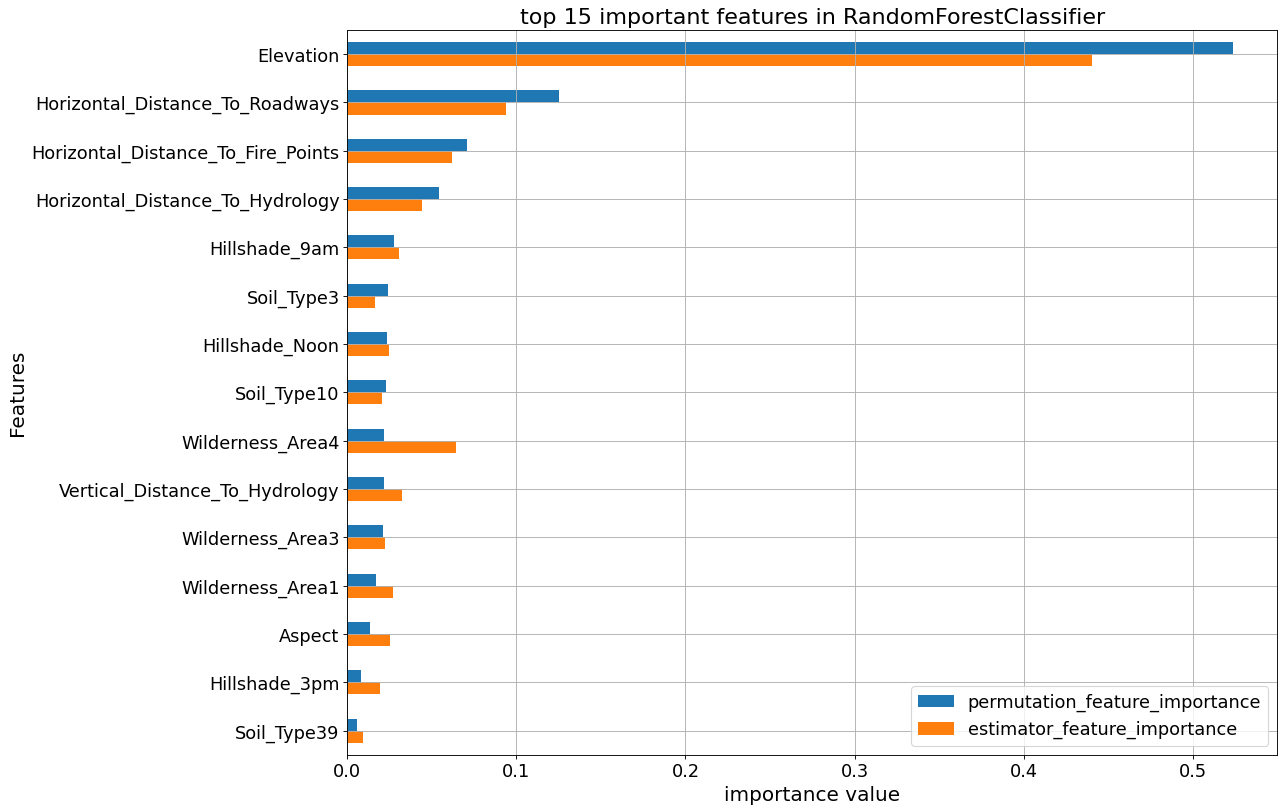

********** GradientBoostingClassifier **********
dict_keys(['importances_mean', 'importances_std', 'importances'])


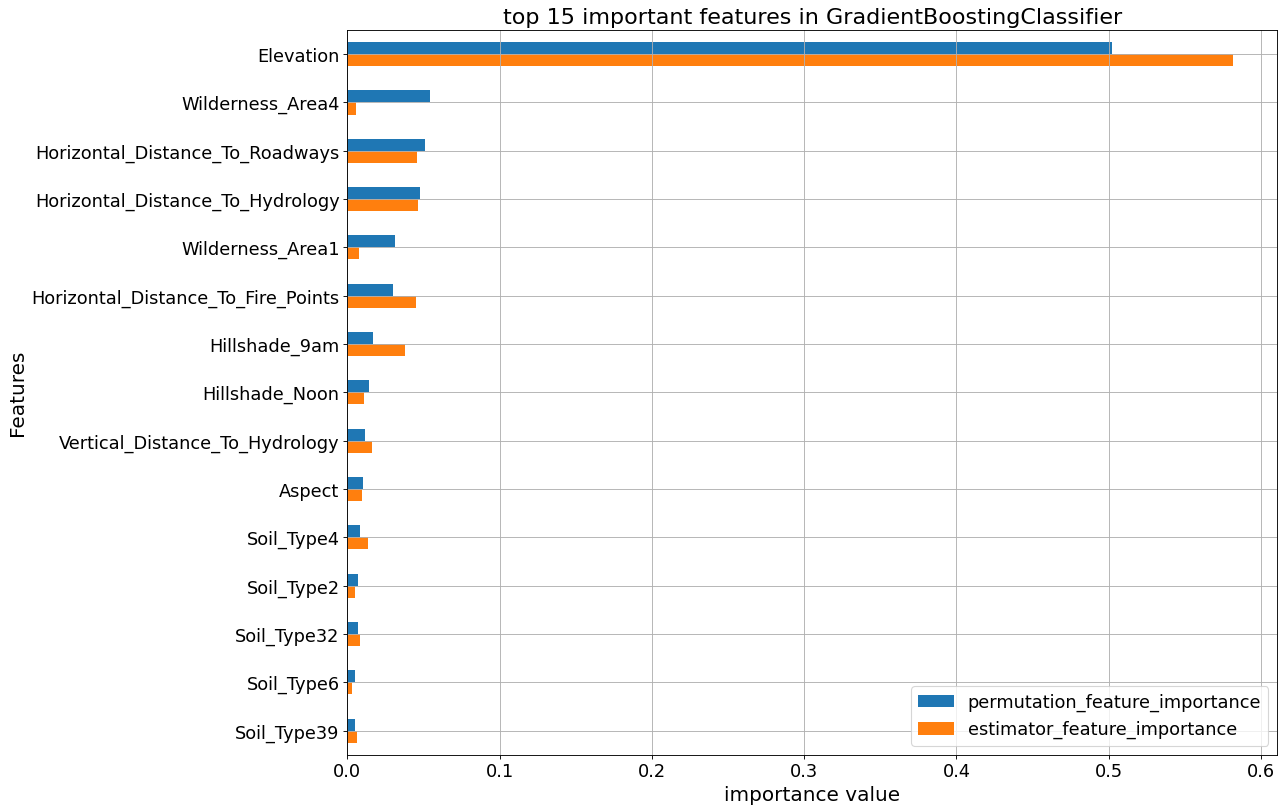

********** XGBClassifier **********
dict_keys(['importances_mean', 'importances_std', 'importances'])


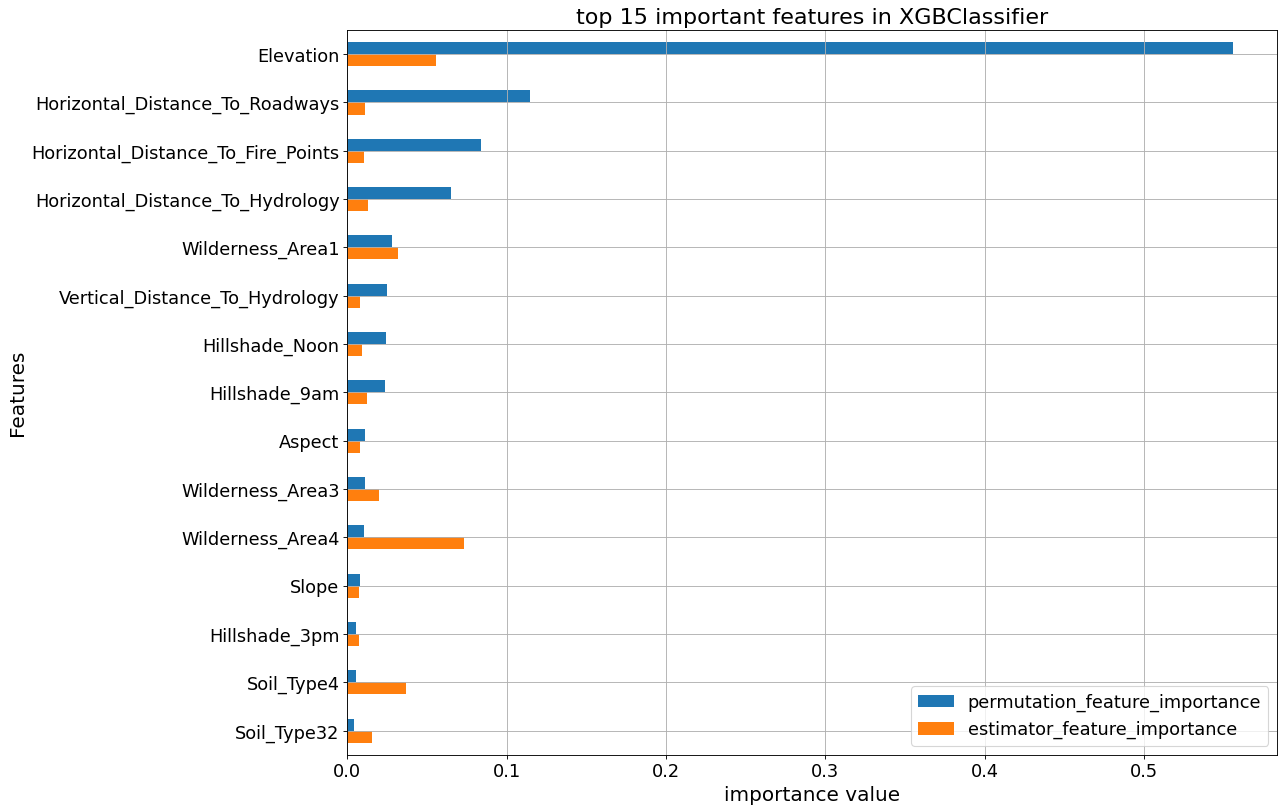

In [ ]:
for i, estimator in enumerate(tree_list):
  print(f"********** {est_dict[estimator][0].__class__.__name__} **********")
  df_importance = important_features(estimator=estimator, est_dict=est_dict, 
                                     X_val=X_val, y_val=y_val, selected_feat=selected_feat, n_feat=15, n_repeats=5)

### XGBoost early stop 

XGBoost can stop the fitting process once the validation error does not improve after a certain number tries.

In [ ]:
# XGBoost early stop fit
xform = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(),
)

xform.set_params(functiontransformer__kw_args = kwargs_dict)

X_train_xform = xform.fit_transform(X_train)
X_val_xform = xform.transform(X_val)

clf = XGBClassifier(
    n_estimators = 1000,
    max_depth=8,
    learning_rate=0.5,
    num_parallel_tree = 10,
    n_jobs=-1
)

#eval_set
eval_set = [(X_train_xform, y_train), (X_val_xform, y_val)]

clf.fit(X_train_xform, y_train, 
          eval_set=eval_set, 
          eval_metric=['merror', 'mlogloss'], 
          early_stopping_rounds=50,
          verbose=False) # Stop if the score hasn't improved in 50 rounds

print('Training Accuracy:', clf.score(X_train_xform, y_train))
print('Validation Accuracy:', clf.score(X_val_xform, y_val))
# y_pred = clf.predict(X_val_xform)


Training Accuracy: 0.9987599206349206
Validation Accuracy: 0.8528439153439153


dict_keys(['validation_0', 'validation_1'])


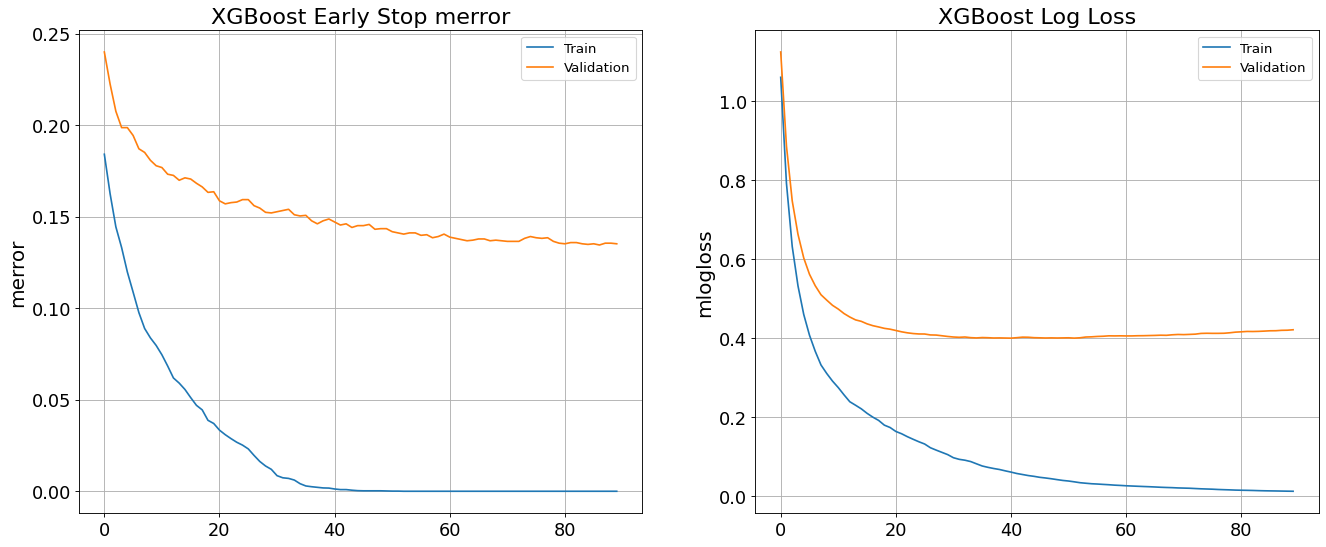

In [ ]:
# import matplotlib.pyplot as plt
# retrieve performance metrics
results = clf.evals_result()
print(results.keys())

# number of successful rounds before early stop fitting
# 'validation_0' : training data, 'validation_1': val data
n_rounds = len(results['validation_1']["merror"])
xdat = range(0, n_rounds)

# plot classification error
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].plot(xdat, results['validation_0']['merror'], label='Train')
ax[0].plot(xdat, results['validation_1']['merror'], label='Validation')
ax[0].set_ylabel('merror', fontsize=18)
ax[0].set_title('XGBoost Early Stop merror', fontsize=20)


ax[1].plot(xdat, results['validation_0']['mlogloss'], label='Train')
ax[1].plot(xdat, results['validation_1']['mlogloss'], label='Validation')
ax[1].set_ylabel('mlogloss', fontsize=18)
ax[1].set_title('XGBoost Log Loss', fontsize=20)

for axi in ax:
  axi.legend(fontsize=12)
  axi.tick_params(axis='both', labelsize=16)
  axi.grid()

plt.show()

### Cross Validation Curve: 

split the train set into train and validation in multiple folds. Determine training and test scores for different values of a specified parameter. This is similar to grid search with one parameter. 

********** RandomForestClassifier **********
**** randomforestclassifier__max_features ****

val scores mean:
 [0.7948082  0.80555556 0.80745701 0.81357474 0.82498347 0.82242063
 0.81861772 0.82374339 0.82465278 0.82564484 0.82440476 0.82829034]
**** randomforestclassifier__max_depth ****

val scores mean:
 [0.71205357 0.76322751 0.79117063 0.8172123  0.82374339 0.82746362
 0.82795966]
**** randomforestclassifier__min_samples_split ****

val scores mean:
 [0.82919974 0.82878638 0.82374339 0.81845238 0.81754299 0.81241733
 0.80613426 0.80241402 0.80266204 0.79902447]
**** randomforestclassifier__min_samples_leaf ****

val scores mean:
 [0.82374339 0.81605489 0.80233135 0.79323743 0.78199405 0.77372685
 0.76438492 0.7582672  0.7547123  0.74892526]
**** randomforestclassifier__criterion ****

val scores mean:
 [0.81836971 0.82374339]
********** GradientBoostingClassifier **********
**** gradientboostingclassifier__max_features ****

val scores mean:
 [0.73553241 0.75876323 0.77017196 0.77

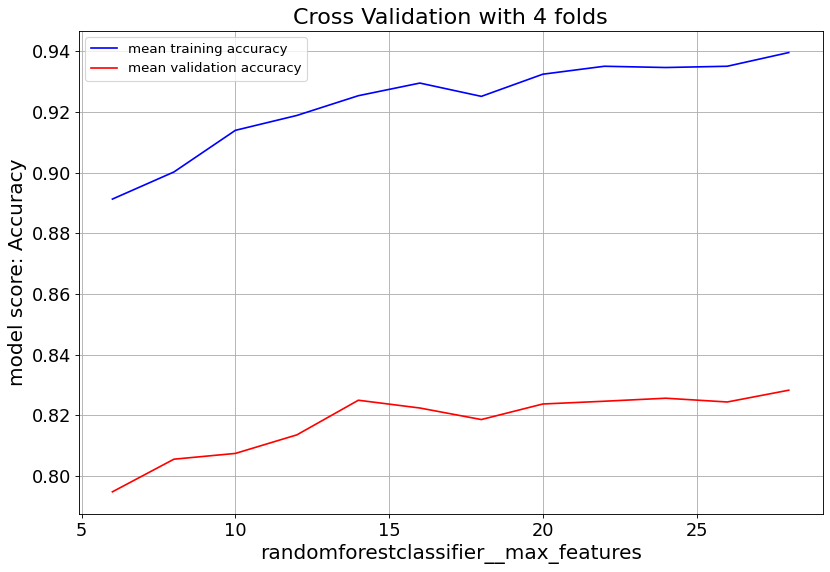

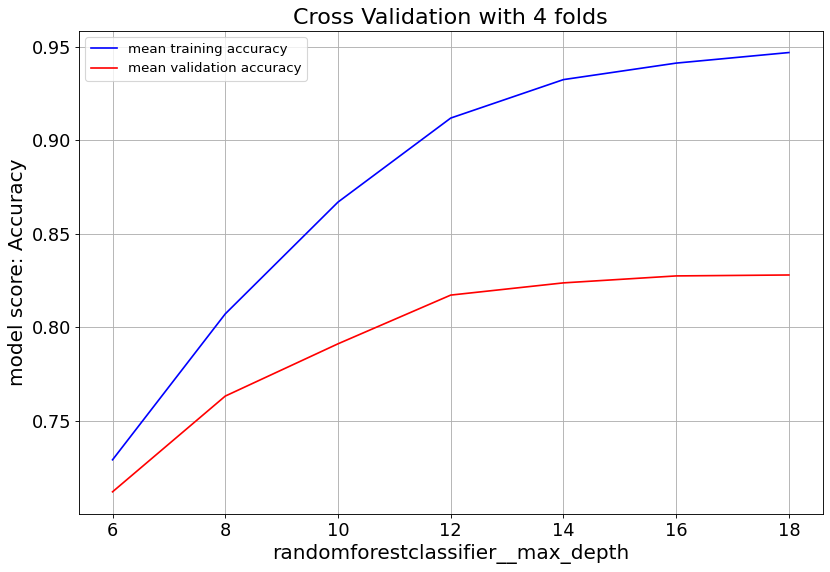

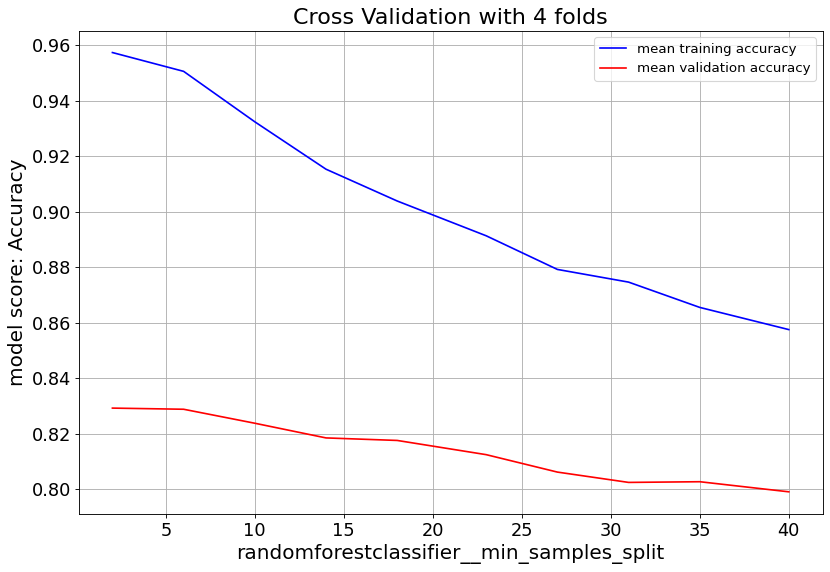

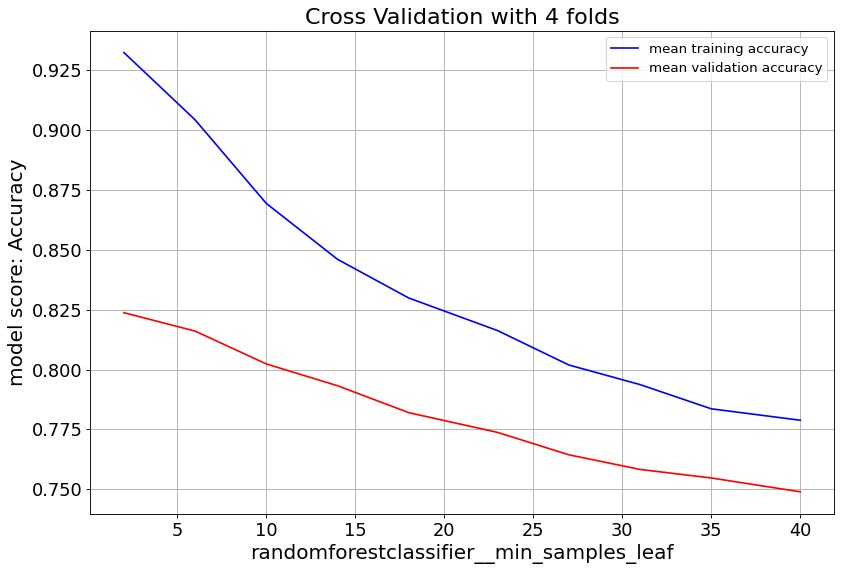

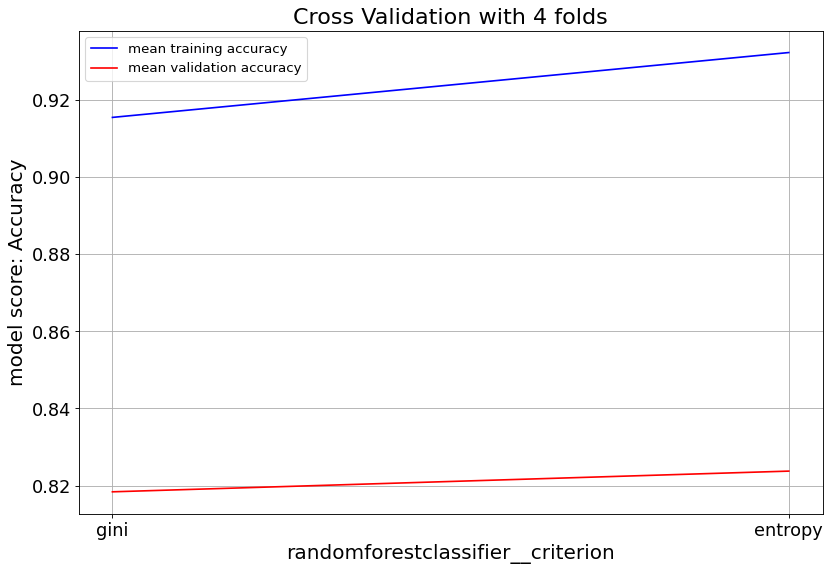

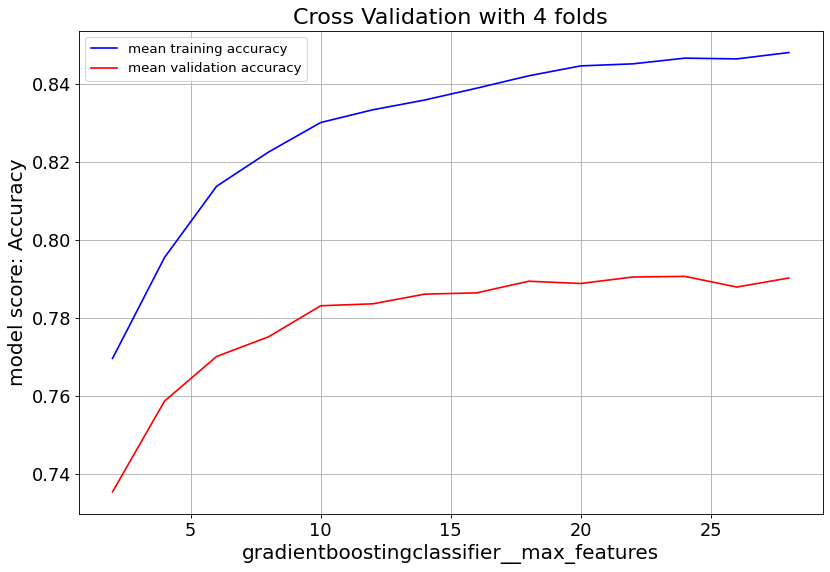

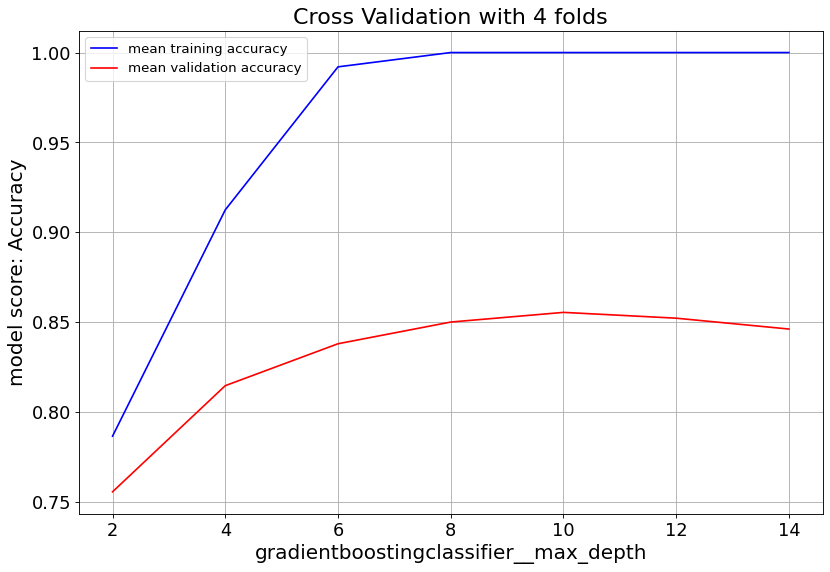

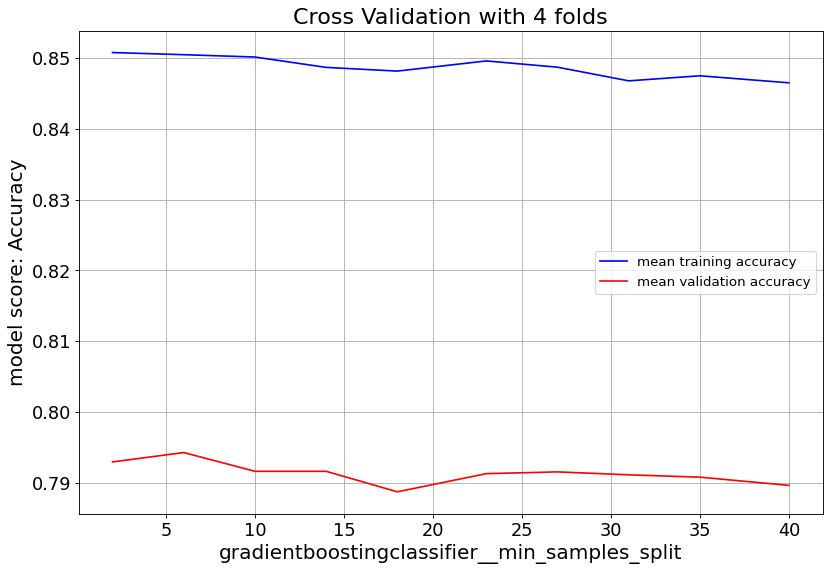

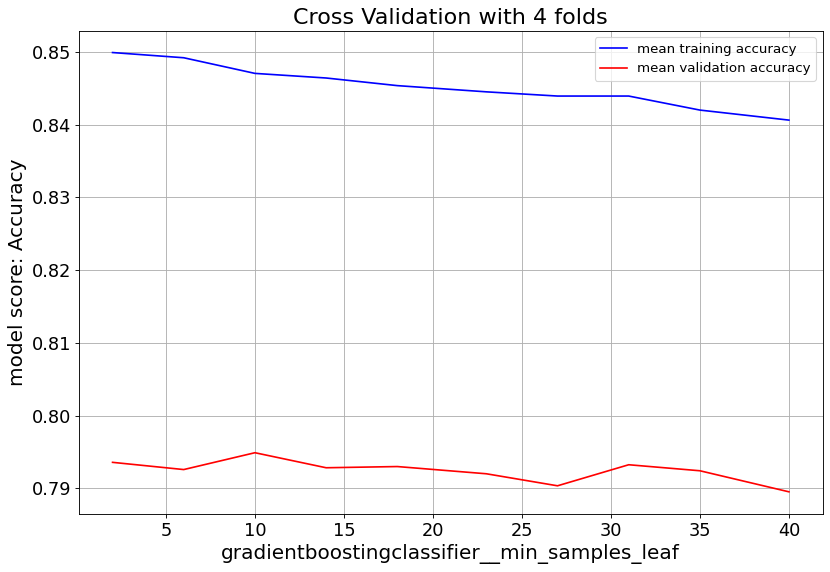

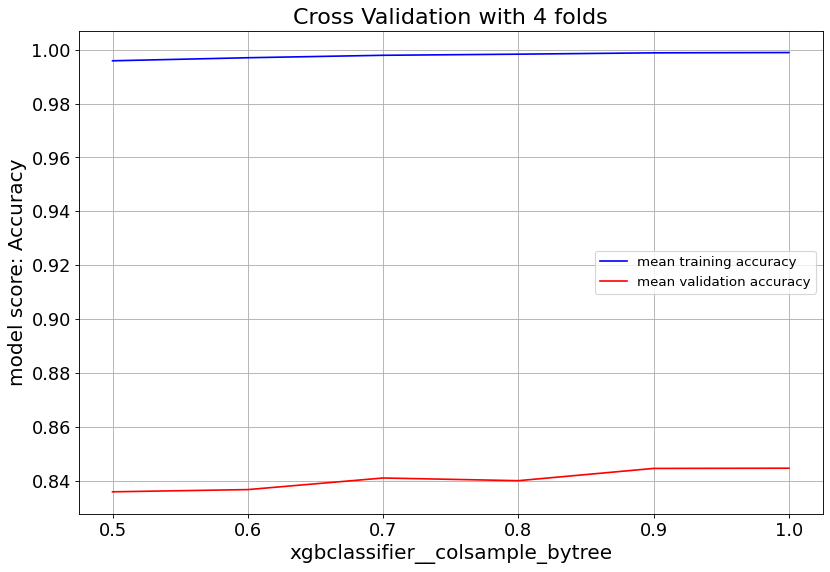

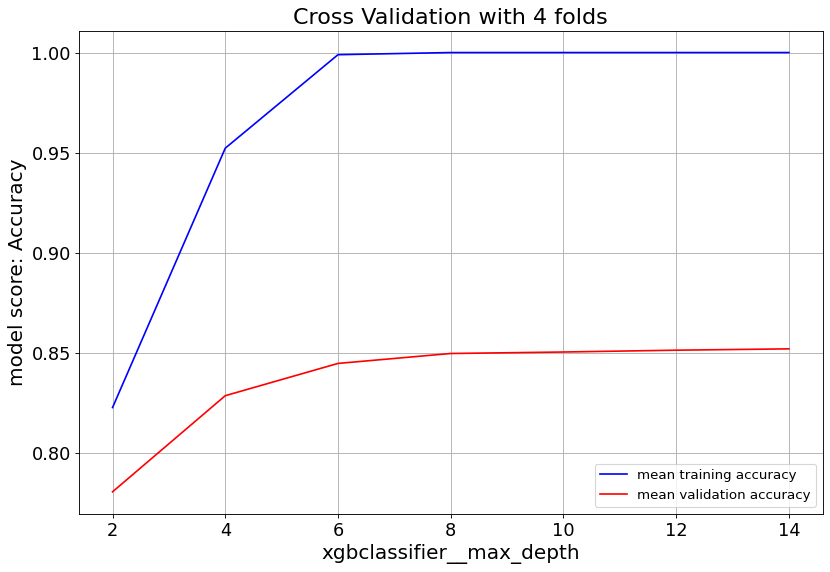

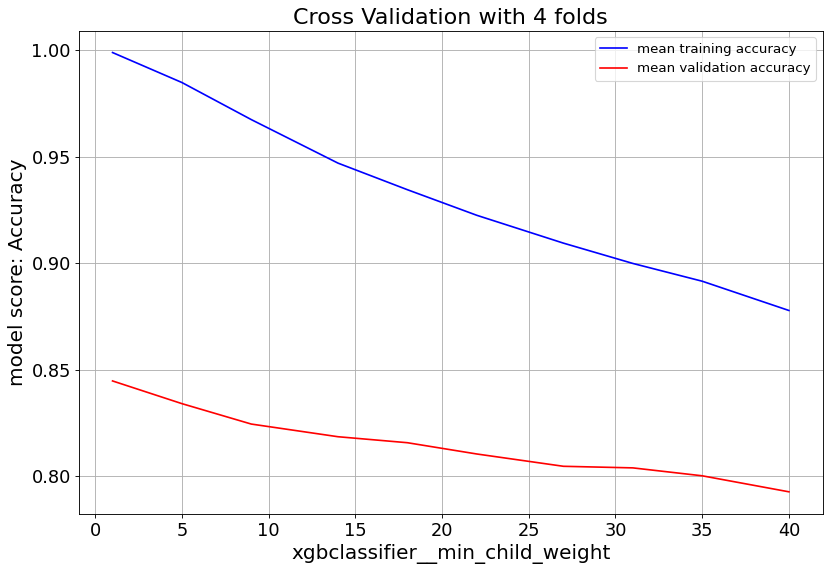

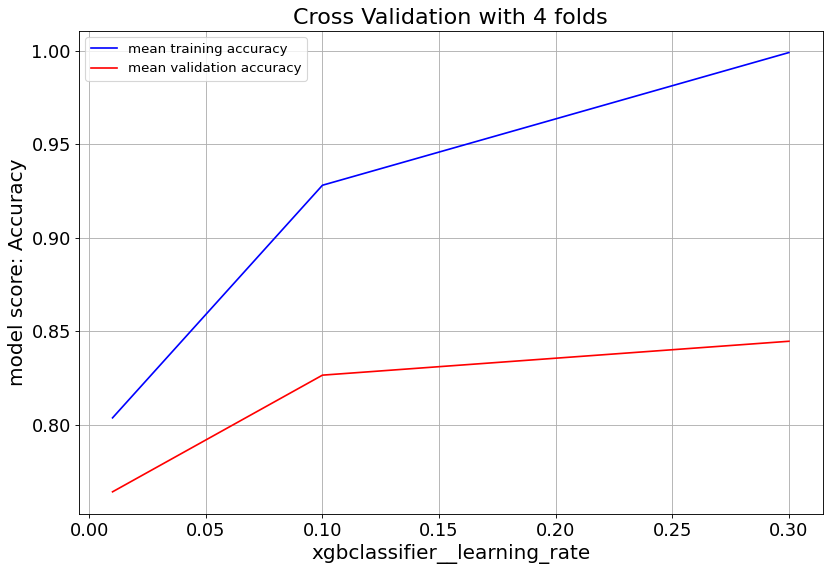

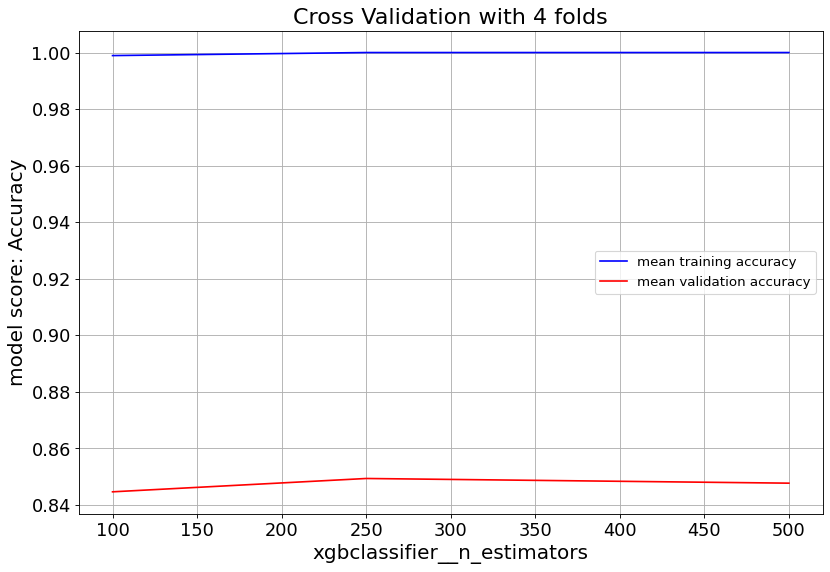

In [ ]:
kfold=4
for k, estimator in enumerate(tree_list):
  print(f"********** {est_dict[estimator][0].__class__.__name__} **********")
  classifier_name = clf_name(estimator, est_dict)  
  # estimator.set_params(functiontransformer__kw_args = kwargs_dict)
  # print(est_dict[estimator][1])
  
  param_distributions = {classifier_name.lower()+'__'+ est_dict[estimator][1][j]: est_dict[estimator][2][j] for j in range(len(est_dict[estimator][1]))}
  
  for i in range(len(est_dict[estimator][1])):
    param_name=classifier_name.lower()+'__'+ est_dict[estimator][1][i]
    param_range = est_dict[estimator][2][i]
    estimator.set_params(functiontransformer__kw_args = kwargs_dict)

    train_scores, val_scores = validation_curve(estimator, X_train, y_train,
    # param_name='functiontransformer__kw_args',
    param_name=param_name, 
    param_range=param_range, 
    scoring='accuracy', cv=kfold, n_jobs=-1, verbose=0
    )

    print(f'**** {param_name} ****\n')
    print("val scores mean:\n", np.mean(val_scores, axis=1))

    # Averaging CV scores
    fig, ax = plt.subplots(figsize=(12,8))

    ax.plot(param_range, np.mean(train_scores, axis=1), color='blue', label='mean training accuracy')
    ax.plot(param_range, np.mean(val_scores, axis=1), color='red', label='mean validation accuracy')
    ax.set_title(f'Cross Validation with {kfold:d} folds', fontsize=20)
    ax.set_xlabel(param_name, fontsize=18)
    ax.set_ylabel('model score: Accuracy', fontsize=18)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(which='both')



### RandomizedSearchCV

RandomizedSearchCV implements a “fit” and a “score” method. The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In [ ]:
kfold=4
n_iter = 10
best_ests = [np.NaN]*len(est)
best_scores = [np.NaN]*len(est)
best_params = [np.NaN]*len(est)

for i, estimator in enumerate(est):
  print(f"\n********** {est_dict[estimator][0].__class__.__name__} **********")
  estimator.set_params(functiontransformer__kw_args = kwargs_dict)

  classifier_name = clf_name(estimator=estimator, est_dict=est_dict)
  print(est_dict[estimator][1])
  
  param_distributions = {classifier_name.lower()+'__'+ est_dict[estimator][1][j]: 
                         est_dict[estimator][2][j] for j in range(len(est_dict[estimator][1]))}

  print("before RSCV")
  rscv = RandomizedSearchCV(estimator, param_distributions=param_distributions, 
    n_iter=n_iter, cv=kfold, scoring='accuracy', verbose=1, return_train_score=True, 
    n_jobs=-1)
  
  print("after RSCV")
  rscv.fit(X_train, y_train)
  best_ests[i] = rscv.best_estimator_
  best_scores[i] = rscv.best_score_
  best_params[i] = rscv.best_params_

print("after loop ##################")

print('Cross-validation Accuracy', best_scores)
print('Best hyperparameters', best_params)
print('Best estimator',best_ests )



********** LogisticRegression **********
['solver']
before RSCV
after RSCV
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   31.0s finished



********** RidgeClassifier **********
['alpha']
before RSCV
after RSCV
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



********** RandomForestClassifier **********
['max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion']
before RSCV
after RSCV
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.3s finished



********** GradientBoostingClassifier **********
['max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf']
before RSCV
after RSCV
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.9min finished



********** XGBClassifier **********
['colsample_bytree', 'max_depth', 'min_child_weight', 'learning_rate', 'n_estimators']
before RSCV
after RSCV
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 17.1min finished


after loop ##################
Cross-validation Accuracy [0.7080026455026454, 0.6332671957671958, 0.7709986772486773, 0.8645833333333334, 0.8445767195767195]
Best hyperparameters [{'logisticregression__solver': 'newton-cg'}, {'ridgeclassifier__alpha': 0.01}, {'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__min_samples_leaf': 14, 'randomforestclassifier__max_features': 10, 'randomforestclassifier__max_depth': 12, 'randomforestclassifier__criterion': 'gini'}, {'gradientboostingclassifier__min_samples_split': 35, 'gradientboostingclassifier__min_samples_leaf': 10, 'gradientboostingclassifier__max_features': 26, 'gradientboostingclassifier__max_depth': 14}, {'xgbclassifier__n_estimators': 100, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__max_depth': 14, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__colsample_bytree': 0.5}]
Best estimator [Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=

In [ ]:
best_feat = best_ests[3].named_steps['functiontransformer'].transform(X_train).columns
best_feat, best_feat.shape

(Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
        'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
        'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
        'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
        'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
        'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
        'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
        'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
        'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
        'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
       dtype='obje

* RandomizedSerachCV cross validates the model solely based on the training data by folding it into training and validation sets. Now we can predict the target label based on the test data that has been held back from the model untill now. The accuracy metric of the test data confirms the validity of our cross validation approach.

In [ ]:
print("predicting ...")
best_ypreds = [best_est.predict(X_val) for best_est in best_ests]
best_testscores = [accuracy_score(y_val, best_ypred) for best_ypred in best_ypreds]
print('Test accuracy\n', best_testscores)
print('best cross validation accuracy\n', best_scores)


predicting ...
Test accuracy
 [0.6911375661375662, 0.6326058201058201, 0.7754629629629629, 0.8700396825396826, 0.8498677248677249]
best cross validation accuracy
 [0.7080026455026454, 0.6332671957671958, 0.7709986772486773, 0.8645833333333334, 0.8445767195767195]


###Partial dependance plot

In [ ]:
# 
xform = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(),
)


xform.set_params(functiontransformer__kw_args = kwargs_dict)

X_train_xform = xform.fit_transform(X_train)
X_val_xform = xform.transform(X_val)

model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


model.fit(X_train_xform, y_train)


print('Training Accuracy:', model.score(X_train_xform, y_train))
print('Validation Accuracy:', model.score(X_val_xform, y_val))

y_pred = model.predict(X_val_xform)

Training Accuracy: 0.9002149470899471
Validation Accuracy: 0.8128306878306878


In [ ]:
model.classes_

array([1, 2, 3, 4, 5, 6, 7])

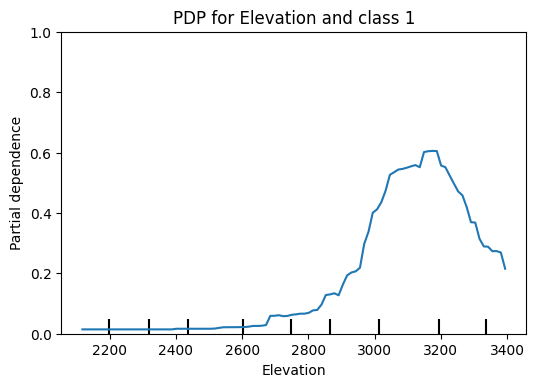

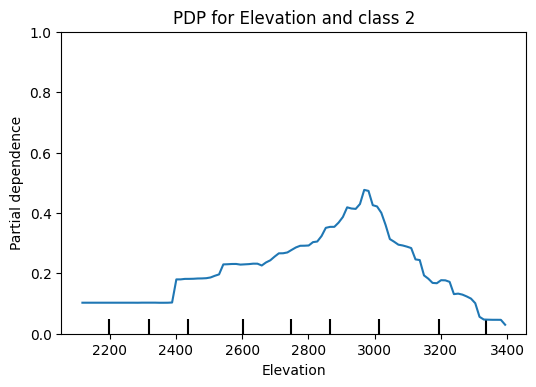

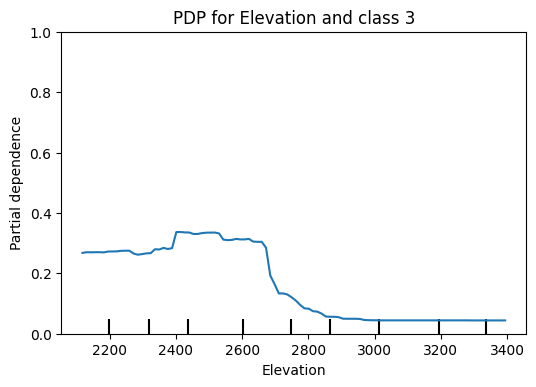

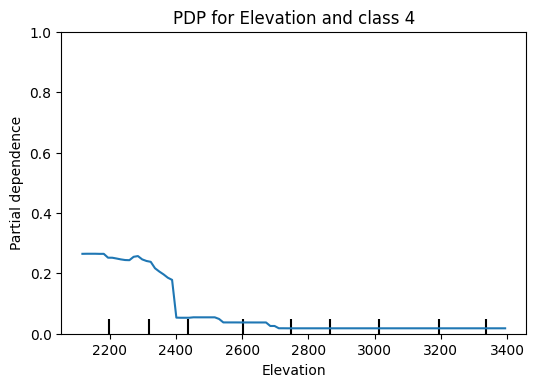

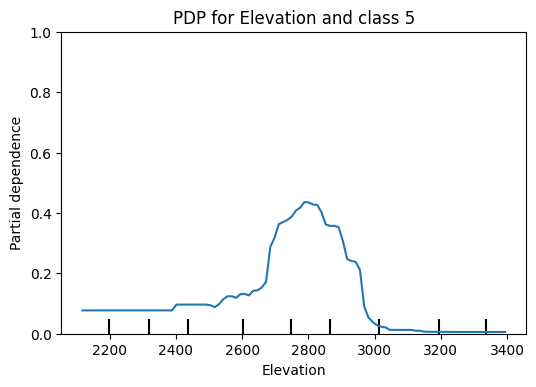

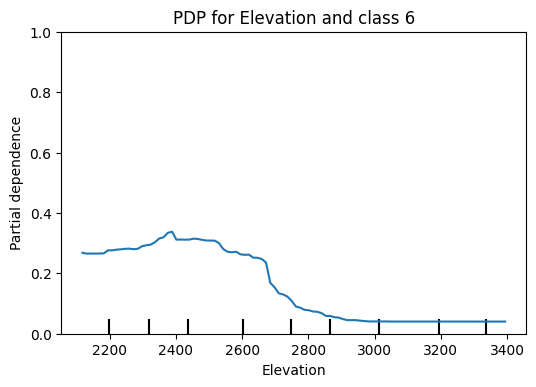

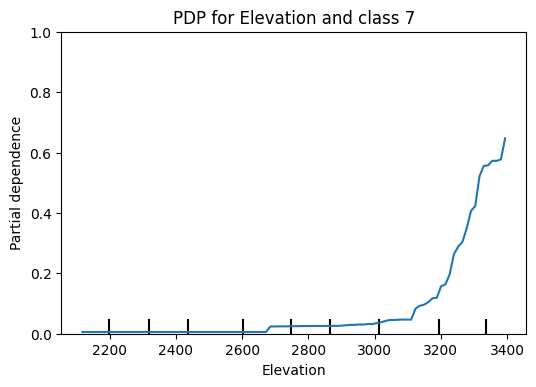

In [ ]:
# In sklearn
from sklearn.inspection import partial_dependence, plot_partial_dependence

feature = ['Elevation']

for t in model.classes_:
  plot_partial_dependence(model, X_val_xform, feature, target=t)
  plt.ylim((0,1))
  plt.title(f'PDP for Elevation and class {t}')

In [ ]:
# In pdp
%%capture
!pip install pdpbox

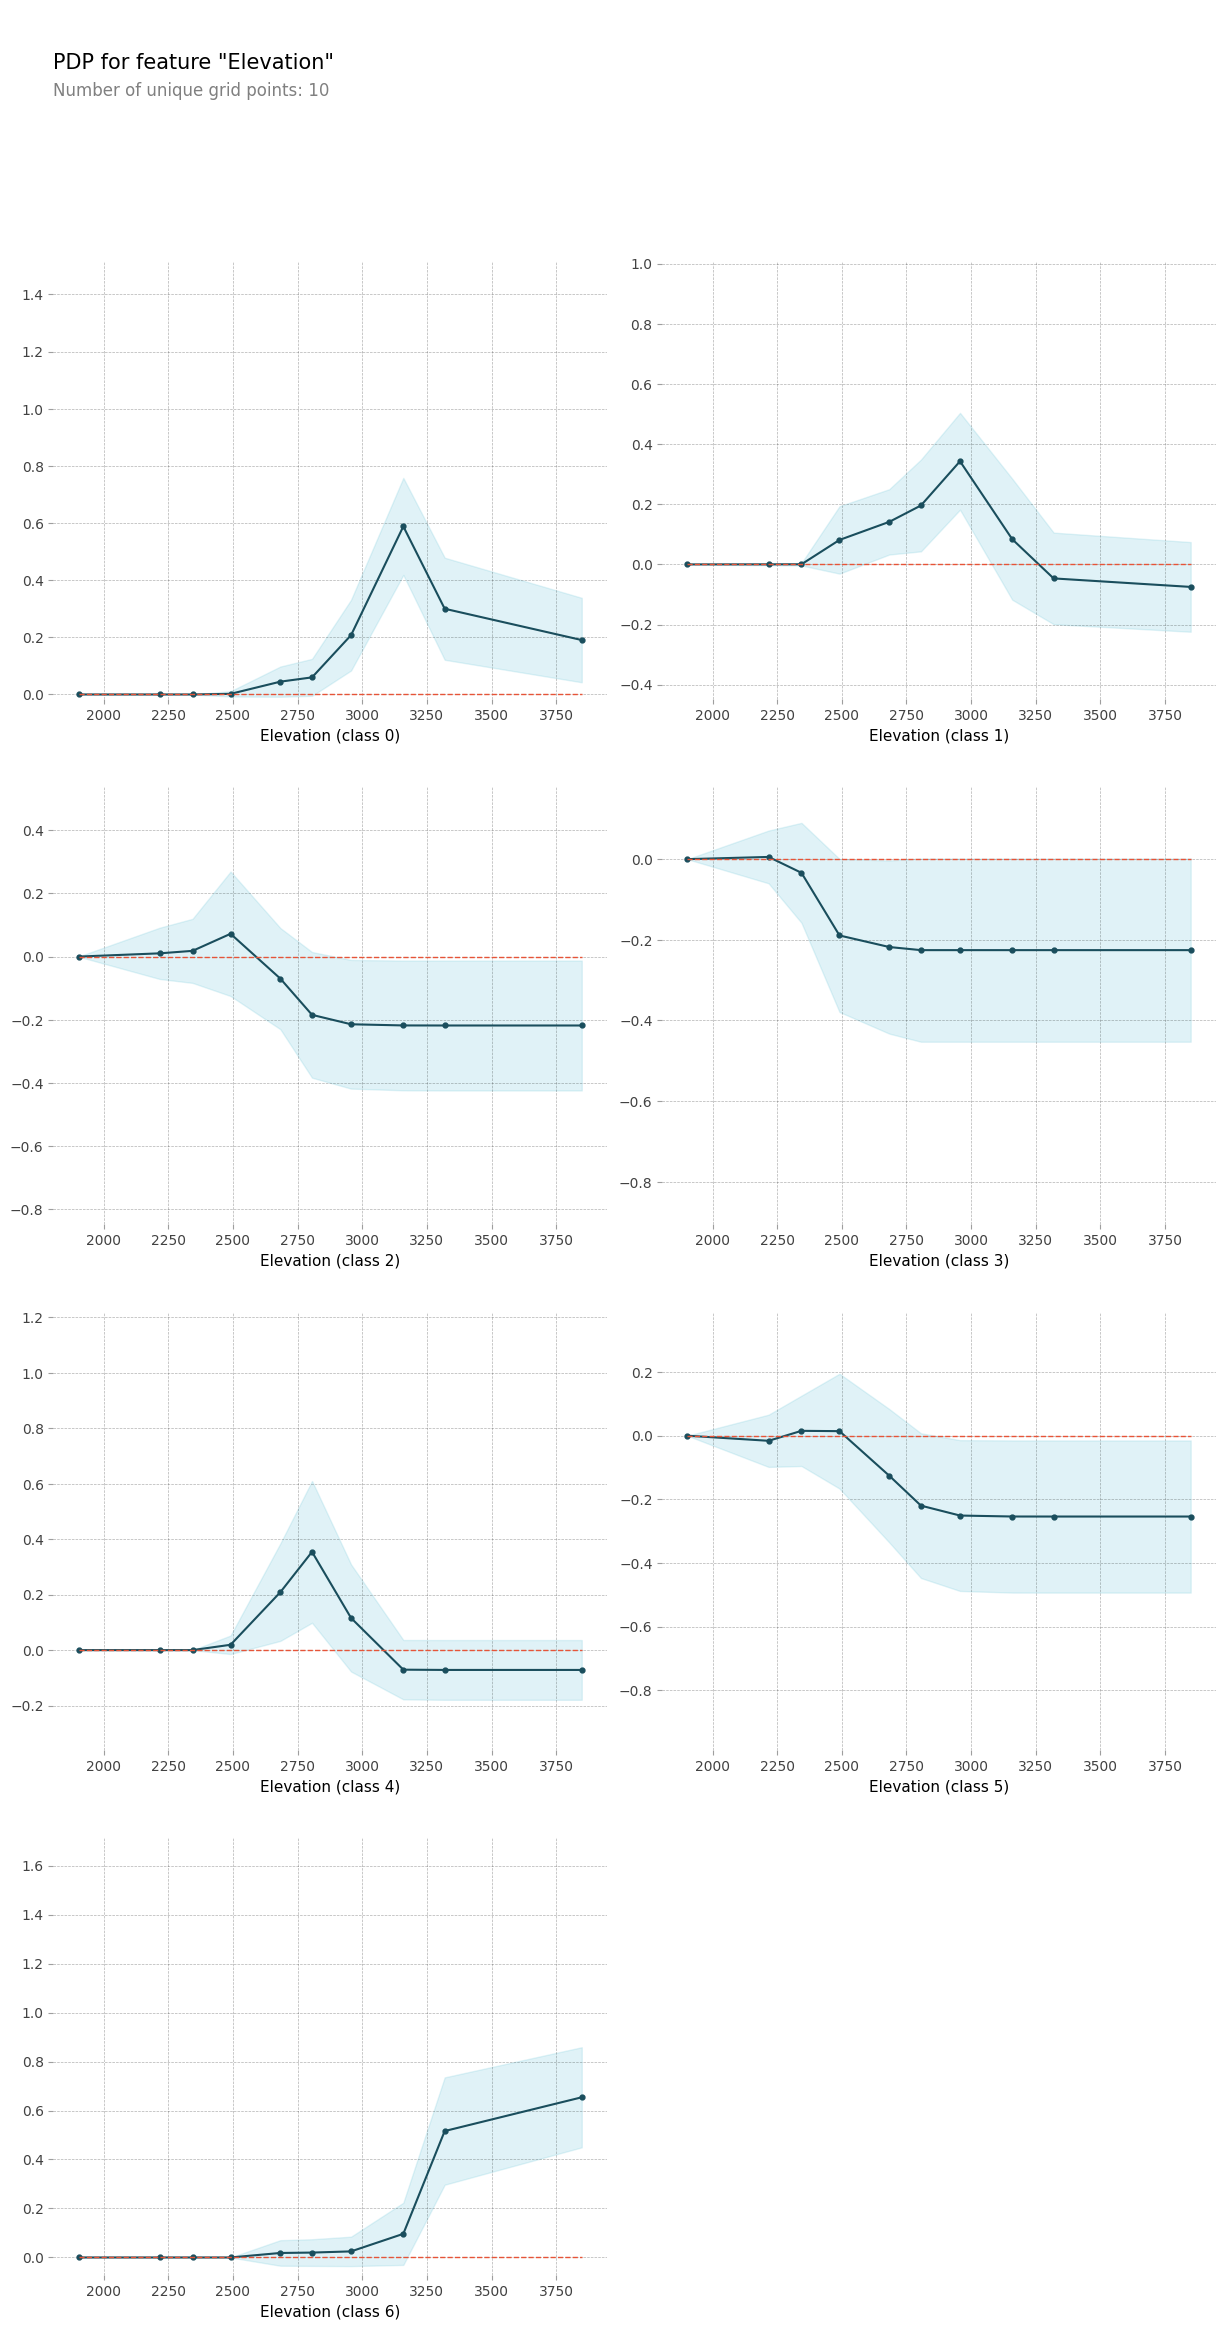

In [ ]:
from pdpbox import pdp

feature = 'Elevation'
pdp_dist = pdp.pdp_isolate(model=model, 
                           dataset=X_val_xform, 
                           model_features=X_val_xform.columns, 
                           feature=feature)
pdp.pdp_plot(pdp_dist, feature, plot_lines=False);

In [ ]:
df_importance.head()

,feature,permutation_importance,importances_std,feature_importance
1,Elevation,0.4634,0.004409,0.109122
14,Wilderness_Area4,0.0840,0.003254,0.080284
11,Wilderness_Area1,0.0442,0.001840,0.023553
4,Horizontal_Distance_To_Hydrology,0.0368,0.001282,0.020905
6,Horizontal_Distance_To_Roadways,0.0286,0.002444,0.012610


In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
features = ['Horizontal_Distance_To_Hydrology', 'Wilderness_Area4']

interaction = pdp_interact(
    model=model,
    dataset=X_val_xform,
    model_features=X_val_xform.columns,
    features=features
)

(<Figure size 1500x3200 with 15 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fbaacb62a20>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fbaafd3bf98>})

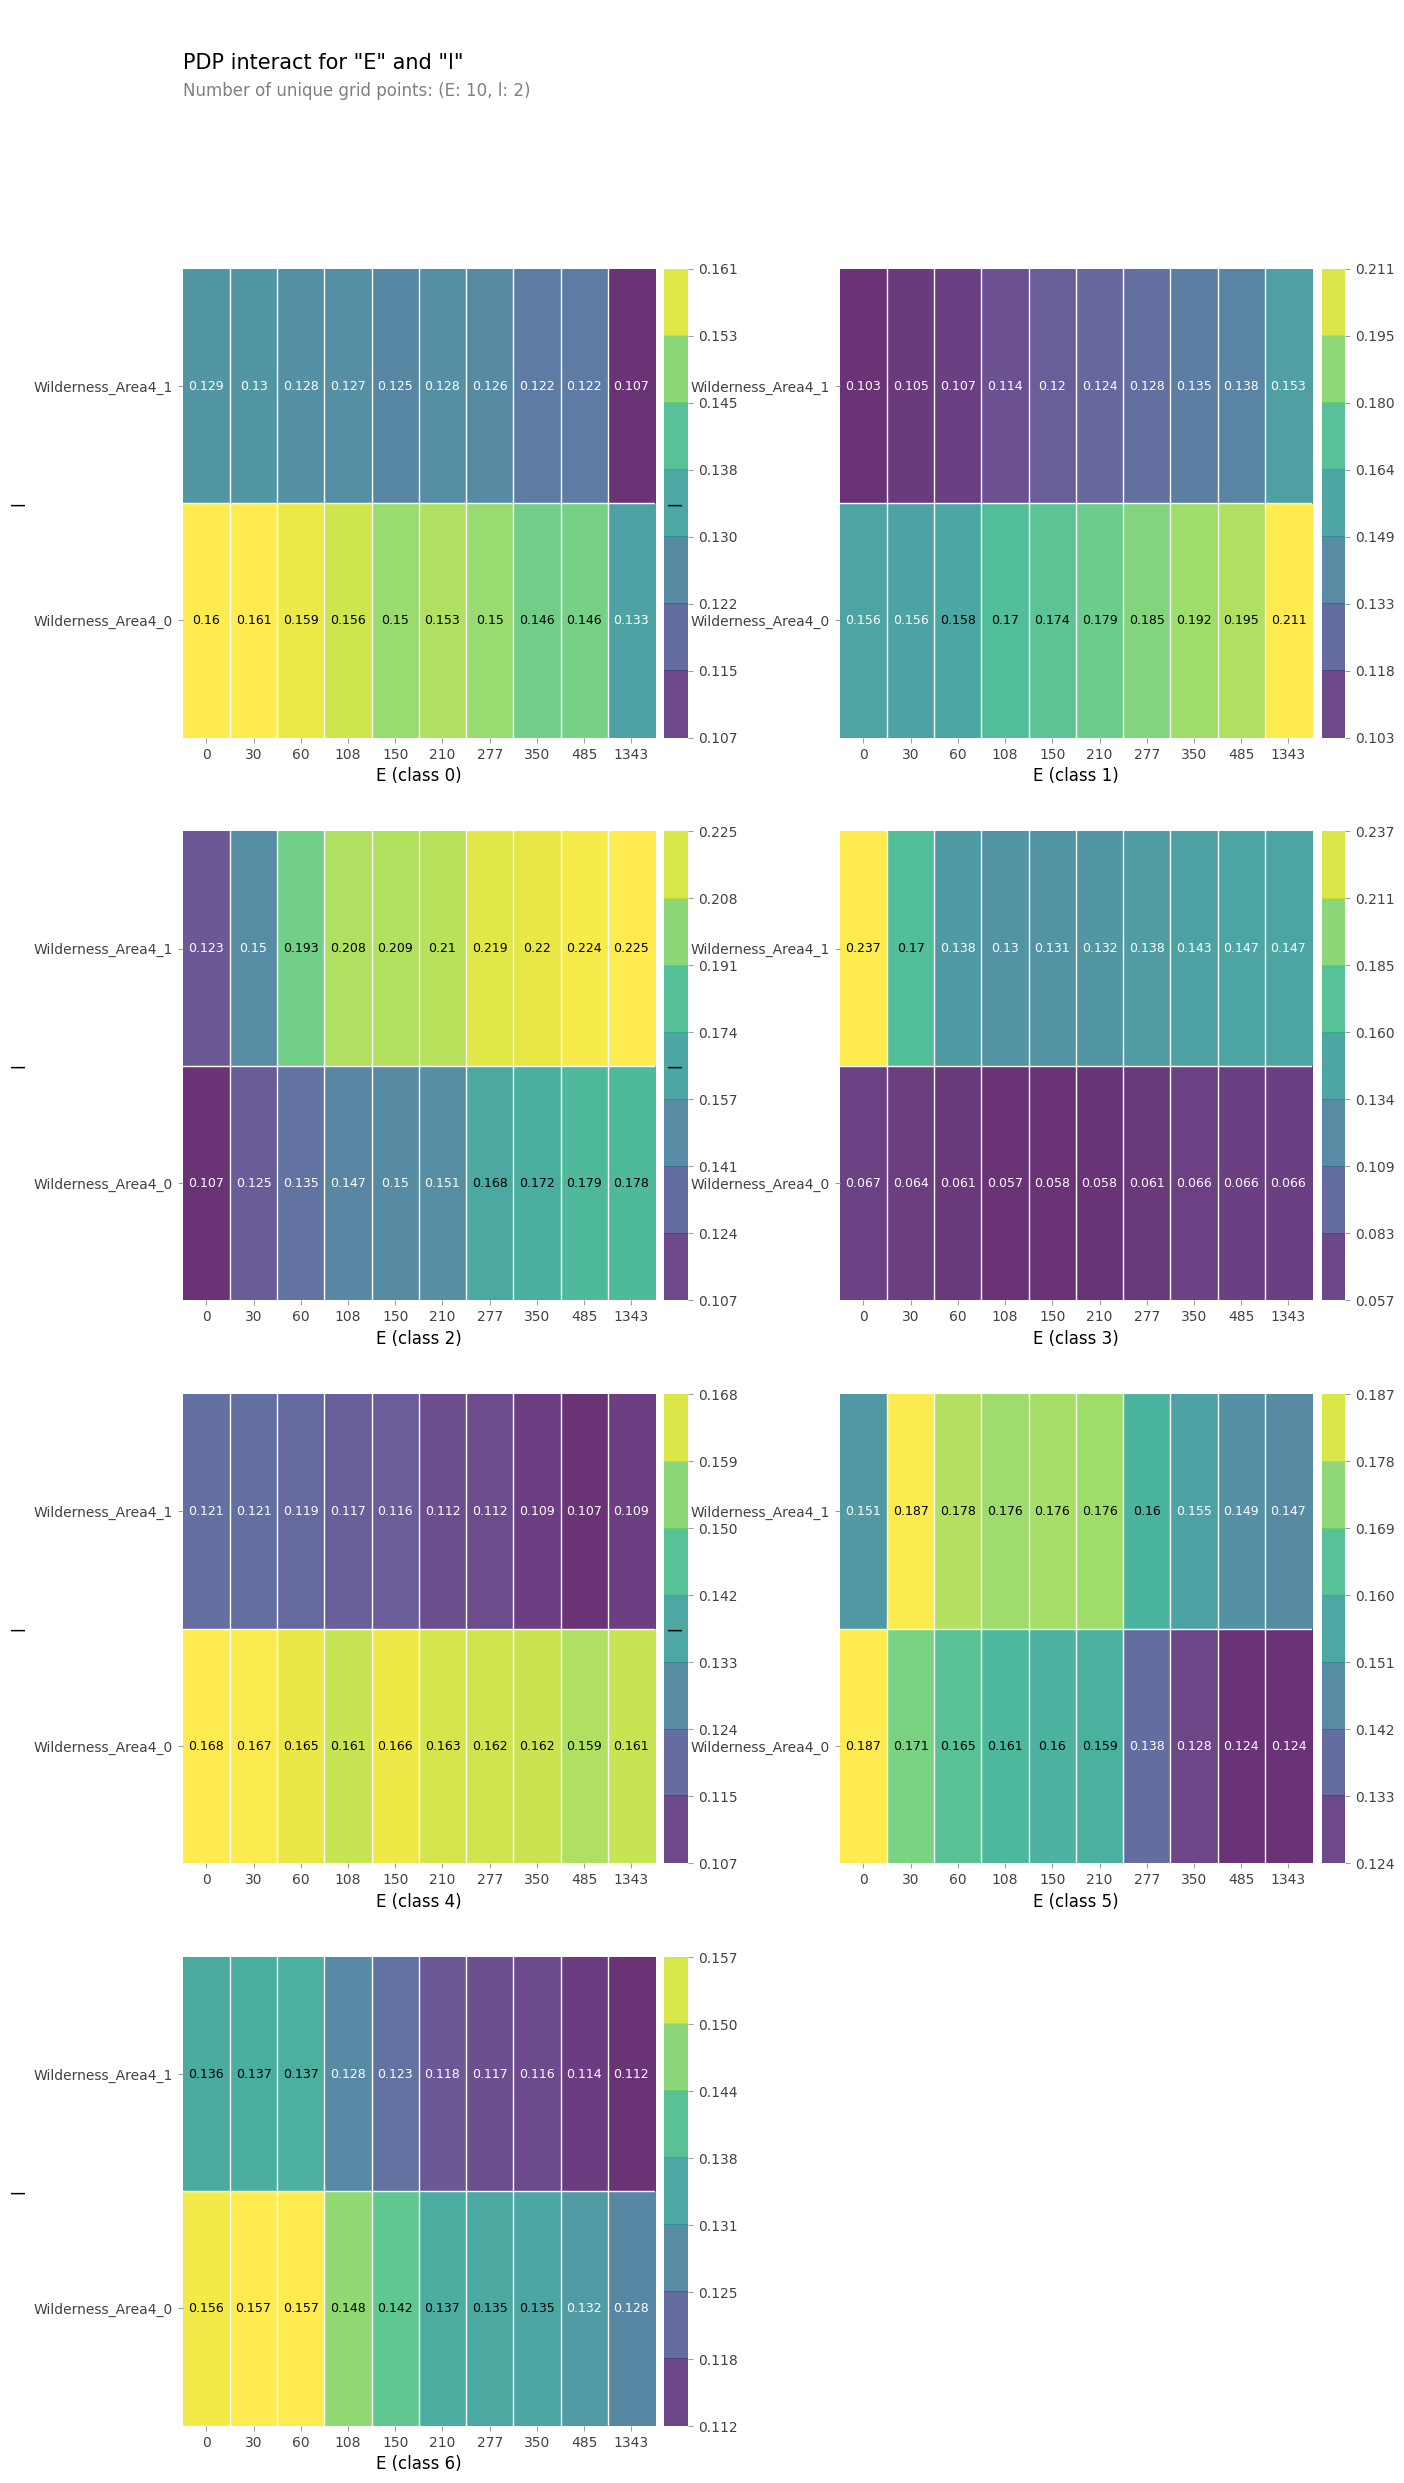

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)

### Shaply

In [ ]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.
row = X_val_xform.iloc[[0]]
row

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type26,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
3551,2311,102,25,525,17,1392,252,199,59,947,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# What was the actual rent for this apartment?
y_val.iloc[[0]]

3551    4
Name: Cover_Type, dtype: int64

In [ ]:
# What does the model predict for this apartment?
model.predict(row)

array([4])

In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 2.6MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394114 sha256=1d9313b5c680913c098b2035763bd55903ccdfa72430155c1b6179df426125d6
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(row)
# shap.initjs()
# shap.force_plot(
#     base_value=explainer.expected_value,
#     shap_values=shap_values,
#     features=row
# )